### **Section 5.5 - CoT Effect On Diversity Based Prompt Selection Experiment Results**
Performed on the `DRAW-1K` dataset where math equations are included as the ground truth

### **Import libraries**
`lab_v2` is a library containing methods that are often used throughout our GPT experiments.  
This library can be found at the following url:

In [43]:
import pandas as pd
import numpy as np

from lab_v2 import io
import matplotlib.pyplot as plt

### **Constants**
Specify a few constants to make the notebook easier to configure in the future.

In [44]:
APPEND = 'T0.7'
SAMPLE = '19'

DATASETS = [
    'draw',
    'draw-cot',
]

NUM_PROMPTS = int(SAMPLE) + 1
FEATURES = ['shannon_entropy', 'gini_impurity', 'majority_distance']
FOLDERS = ['entropy', 'gini', 'centroid']


### **Trial based on Minimum & Maximum Features**

In [45]:
def trial_ml(num_files):
    all_results = {}
    feature_results = {}
    other_results = {}

    for FEATURE, FOLDER in zip(FEATURES, FOLDERS):
        output_file_min = f'../../data/few-shot/trial/{FOLDER}/{DATA}/trial-{DATA}_min.jsonl'
        output_file_max = f'../../data/few-shot/trial/{FOLDER}/{DATA}/trial-{DATA}_max.jsonl'
        best_entries_min = {}
        best_entries_max = {}
        total_failure_probability = 0
        min_failure_probability = float('inf')
        max_failure_probability = float('-inf')
        best_results_correct_probabilities_min = []
        best_results_correct_probabilities_max = []
        individual_prob = []
        avg_failures = []
        max_failures = []

        for i in range(num_files):
            trial = io.read_file(f'../../data/few-shot/{DATA}/fs-{i}-{DATA}-T0.7.jsonl')
            failure_probability = 100 - trial['majority_correct'].sum() / len(trial) * 100
            individual_prob.append(failure_probability)
            min_failure_probability = min(failure_probability, min_failure_probability)
            max_failure_probability = max(failure_probability, max_failure_probability)
            total_failure_probability += failure_probability
            avg_failures.append(total_failure_probability/(i+1))
            max_failures.append(max_failure_probability)

            for _, row in trial.iterrows():
                question_id = row['question_id']
                feature = row[FEATURE]
                majority_correct = row['majority_correct']

                if question_id not in best_entries_min:
                    best_entries_min[question_id] = row.to_dict()
                else:
                    if feature < best_entries_min[question_id][FEATURE] or \
                    (feature == best_entries_min[question_id][FEATURE] and majority_correct):
                        best_entries_min[question_id] = row.to_dict()

                if question_id not in best_entries_max:
                    best_entries_max[question_id] = row.to_dict()
                else:
                    if feature > best_entries_max[question_id][FEATURE] or \
                    (feature == best_entries_max[question_id][FEATURE] and majority_correct):
                        best_entries_max[question_id] = row.to_dict()

            best_results_failure_probability_min = 100 - pd.DataFrame.from_dict(best_entries_min, orient='index')['majority_correct'].sum() / len(best_entries_min) * 100
            best_results_correct_probabilities_min.append(best_results_failure_probability_min)

            best_results_failure_probability_max = 100 - pd.DataFrame.from_dict(best_entries_max, orient='index')['majority_correct'].sum() / len(best_entries_max) * 100
            best_results_correct_probabilities_max.append(best_results_failure_probability_max)

        best_results_min = pd.DataFrame.from_dict(best_entries_min, orient='index')
        trial_failure_probability_min = 100 - best_results_min['majority_correct'].sum() / len(best_results_min) * 100
        #print(f"Failure Probability for the trial (min {FOLDER}): {trial_failure_probability_min}%")

        best_results_max = pd.DataFrame.from_dict(best_entries_max, orient='index')
        trial_failure_probability_max = 100 - best_results_max['majority_correct'].sum() / len(best_results_max) * 100
        #(f"Failure Probability for the trial (max {FOLDER}): {trial_failure_probability_max}%")

        best_results_min.to_json(output_file_min.replace('<FOLDER>', FOLDER), orient='records', lines=True)
        best_results_max.to_json(output_file_max.replace('<FOLDER>', FOLDER), orient='records', lines=True)

        best_results_correct_probabilities_min = [{"Number of Samples": index + 1, "Failure Probability": row/100} for index, row in enumerate(best_results_correct_probabilities_min)]
        best_results_correct_probabilities_min = pd.DataFrame(best_results_correct_probabilities_min)

        best_results_correct_probabilities_max = [{"Number of Samples": index + 1, "Failure Probability": row/100} for index, row in enumerate(best_results_correct_probabilities_max)]
        best_results_correct_probabilities_max = pd.DataFrame(best_results_correct_probabilities_max)

        individual_prob = pd.DataFrame(individual_prob)
        avg_failures = pd.DataFrame(avg_failures)
        max_failures = pd.DataFrame(max_failures)

        stats = pd.DataFrame([
            {"Statistic": "Average", "Value (Probability of Failure)": total_failure_probability / num_files / 100},
            {"Statistic": "Maximum", "Value (Probability of Failure)": max_failure_probability / 100},
            {"Statistic": "Minimum", "Value (Probability of Failure)": min_failure_probability / 100},
            {"Statistic": "Trial (Min)", "Value (Probability of Failure)": trial_failure_probability_min / 100},
            {"Statistic": "Trial (Max)", "Value (Probability of Failure)": trial_failure_probability_max / 100}
        ])

        feature_results[FOLDER] = {
            "best_results_correct_probabilities_min": best_results_correct_probabilities_min,
            "best_results_correct_probabilities_max": best_results_correct_probabilities_max,
            "stats": stats,
        }

        other_results = {
            "best_results": best_results_min,
            "individual_prob": individual_prob/100,
            "avg_failures": avg_failures/100,
            "max_failures": max_failures/100
        }

    return feature_results, other_results

In [46]:
def plot_line_results(feature_results, other_results, DATA, min_entropy_selection_draw):
    plt.figure(figsize=[10,6])

    plt.plot(feature_results['entropy']["best_results_correct_probabilities_min"]["Number of Samples"],
             feature_results['entropy']["best_results_correct_probabilities_min"]["Failure Probability"],
             marker='o', color='black', markerfacecolor='white', linestyle='-', label='Minimum Entropy Selection (CoT)')

    plt.plot(feature_results['gini']["best_results_correct_probabilities_min"]["Number of Samples"],
             feature_results['gini']["best_results_correct_probabilities_min"]["Failure Probability"],
             marker='x', linestyle='-', label='Minimum Gini Selection (CoT)')

    plt.plot(feature_results['centroid']["best_results_correct_probabilities_min"]["Number of Samples"],
             feature_results['centroid']["best_results_correct_probabilities_min"]["Failure Probability"],
             marker='^', linestyle='-', label='Minimum Centroid Selection (CoT)')
    
        # If processing 'draw-cot' and the saved result exists, plot it
    if DATA == 'draw-cot' and min_entropy_selection_draw is not None:
        plt.plot(min_entropy_selection_draw["Number of Samples"],
                 min_entropy_selection_draw["Failure Probability"],
                 marker='o', linestyle='--', label='Minimum Entropy Selection (No CoT)')

    x_values = np.arange(1, len(other_results["avg_failures"]) + 1)
    plt.plot(x_values, other_results["avg_failures"], linestyle=(5, (10, 3)), marker='', label='Average Failure Probability (CoT)')
    plt.plot(x_values, other_results["max_failures"], linestyle='-', marker='', label='Maximum Failure Probability Over Prompts (CoT)')

    data_label_mapping = {
        'draw-cot': 'DRAW-1K, CoT',
    }

    label_data = data_label_mapping.get(DATA)


    plt.xlabel("Number of Prompts", fontsize=13, weight='bold')
    plt.ylabel(f"Failure Probability ({label_data})", fontsize=13, weight='bold')
    plt.xticks([0, 5, 10, 15, 20])
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    plt.grid(axis='x', linestyle='-', linewidth=0.5)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
    plt.show()


In [47]:
def plot_bar_results(feature_results, other_results, DATA):
    plt.grid(axis='y', linestyle='-', linewidth=0.5, zorder=0)
    plt.bar(range(1, 21), other_results["individual_prob"].squeeze(), align='edge', edgecolor='black', color='white', width=0.5, zorder=1)

    min_statistic_entropy = feature_results['entropy']['stats'].loc[feature_results['entropy']['stats']['Statistic'] == 'Trial (Min)', 'Value (Probability of Failure)'].squeeze()
    plt.axhline(y=min_statistic_entropy, color='green', linestyle=(5, (10, 3)), linewidth=2, label='Entropy based selection', zorder=2)

    min_statistic_gini = feature_results['gini']['stats'].loc[feature_results['gini']['stats']['Statistic'] == 'Trial (Min)', 'Value (Probability of Failure)'].squeeze()
    plt.axhline(y=min_statistic_gini, color='blue', linestyle='-', label='Gini based selection', zorder=2)

    min_statistic_centroid = feature_results['centroid']['stats'].loc[feature_results['centroid']['stats']['Statistic'] == 'Trial (Min)', 'Value (Probability of Failure)'].squeeze()
    plt.axhline(y=min_statistic_centroid, color='red', linestyle='dotted', linewidth=3, label='Centroid distance based selection', zorder=2)

    data_label_mapping = {
        'draw-cot': 'DRAW-1K, CoT',
    }

    label_data = data_label_mapping.get(DATA)

    plt.ylabel(f"Failure Probability ({label_data})", fontsize=13, weight='bold')
    plt.xlim(0.5, 20.5)
    plt.xticks(range(1, 21), [f'Prompt {i}' for i in range(1, 21)], ha='right', rotation=45)
    plt.tick_params(axis='x', length=0)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
    plt.show()


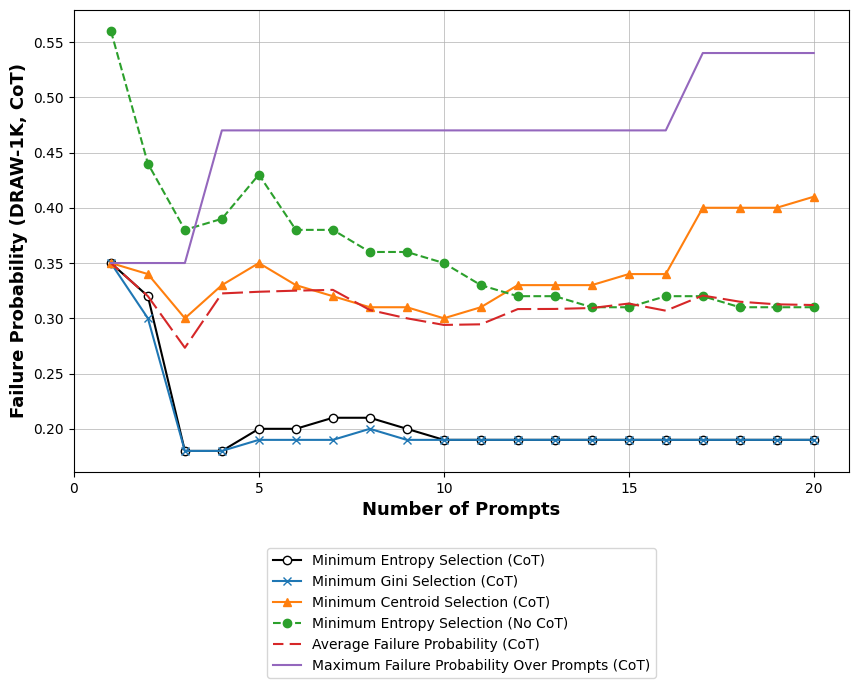

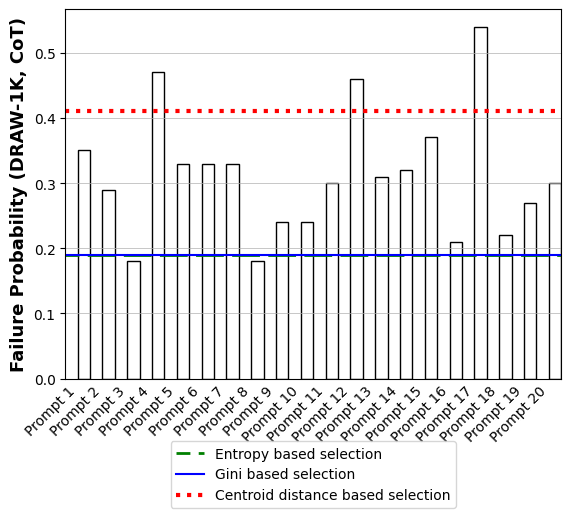

In [48]:
for DATA in DATASETS:

    feature_results, other_results = trial_ml(NUM_PROMPTS)

    # Save the Minimum Entropy Selection result for 'draw' (No CoT)
    if DATA == 'draw':
        min_entropy_selection_draw = feature_results['entropy']["best_results_correct_probabilities_min"]

    # Show the results for DRAW-1K with CoT applied
    if DATA == 'draw-cot':
        plot_line_results(feature_results, other_results, DATA, min_entropy_selection_draw) # to show data for various metrics
        plot_bar_results(feature_results, other_results, DATA) # to show individual probabilities for each prompt